In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers, optimizers
import numpy as np
import matplotlib.pyplot as plt



(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std  = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test  = (x_test-mean)/(std+1e-7)



170498071/170498071 [==============================] - 2s 0us/step


In [4]:
# Original VGG16 architecture, Batch Normalization added, DropOut added

inputs = tf.keras.layers.Input(shape=[32, 32, 3])    
x = inputs

# block 1
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Dropout(0.4)(x)

# block 2
x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Dropout(0.4)(x)

# block 3
x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Dropout(0.4)(x)

# block 4
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Dropout(0.4)(x)

# block 5
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Dropout(0.4)(x)

# FC layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Dense(10, activation = 'softmax')(x)


model = tf.keras.Model(inputs=[inputs], outputs=[x])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0     

In [5]:
#training with adam
batch_size = 256
epochs = 100
lr = 0.0005

opt_adam  = keras.optimizers.Adam(learning_rate=lr)

# data augmentation
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset  = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def process_data(image, label):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.resize(image, (38, 38))
        image = tf.image.random_crop(image, size=[32, 32, 3])
        
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)

    return image, label

train_batches = (train_dataset.shuffle(256*4)
                              .map(process_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                              .batch(batch_size)
                              .prefetch(tf.data.experimental.AUTOTUNE) )

test_dataset = (test_dataset.batch(batch_size))


model.compile(loss='sparse_categorical_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
history = model.fit(train_batches, validation_data=test_dataset, epochs=epochs, verbose=1)

Epoch 1/100
196/196 [==============================] - 16s 31ms/step - loss: 2.2646 - accuracy: 0.3043 - val_loss: 2.5961 - val_accuracy: 0.1186
Epoch 2/100
196/196 [==============================] - 5s 24ms/step - loss: 1.6025 - accuracy: 0.4550 - val_loss: 2.1524 - val_accuracy: 0.3160
Epoch 3/100
196/196 [==============================] - 5s 24ms/step - loss: 1.3982 - accuracy: 0.5232 - val_loss: 1.8846 - val_accuracy: 0.4829
Epoch 4/100
196/196 [==============================] - 5s 24ms/step - loss: 1.5176 - accuracy: 0.5062 - val_loss: 12.9016 - val_accuracy: 0.3643
Epoch 5/100
196/196 [==============================] - 5s 24ms/step - loss: 1.1874 - accuracy: 0.5827 - val_loss: 1.0971 - val_accuracy: 0.6231
Epoch 6/100
196/196 [==============================] - 5s 24ms/step - loss: 1.0355 - accuracy: 0.6368 - val_loss: 1.0005 - val_accuracy: 0.6571
Epoch 7/100
196/196 [==============================] - 5s 24ms/step - loss: 0.9442 - accuracy: 0.6730 - val_loss: 0.9687 - val_accurac

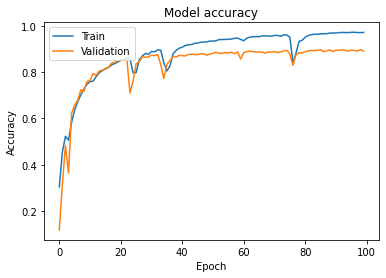

In [6]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

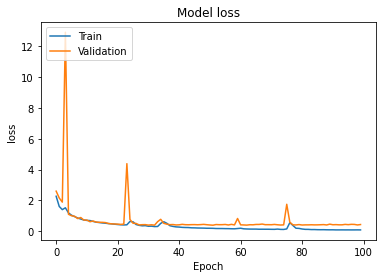

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()